In [348]:
import re
import os

import numpy as np

from cloudmesh.common.Shell import Shell
from cloudmesh.common.util import readfile
from cloudmesh.common.util import writefile
from cloudmesh.common.variables import Variables

import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint

In [349]:
verbose = False

notebook = Shell.map_filename("~/cm/cloudmesh_mllog.log").path

mynotebook = readfile(notebook)
list_of_mllogs = []

count_lines = 0
for line in mynotebook.splitlines():
    #line.replace('\\', '')
    if 'F=' in line and 'S=' in line and 'E=' in line and 'NNSE' in line:
        list_of_mllogs.append(line)
        count_lines += 1
        if verbose:
            print(line)

if verbose:
    print(count_lines)

In [350]:
fixed_dicts = []
for mllog in list_of_mllogs:
    working_line = mllog.strip()
    # print(type(working_line))
    # print(working_line)
    working_line = working_line.replace(':::MLLOG ', '')
    # print('a', working_line)
    working_line = working_line[:-3]
    # print('b', working_line)
    working_line = working_line.replace('\\', '')
    # print('c', working_line)
    working_line = working_line.split(', "metadata":', 1)[0]
    working_line += '}'
    working_line = eval(working_line)
    working_line['value'] = eval(working_line['value'])
    # print('d', working_line)
    # print(type(working_line))

    # interpreting scientific values
    parse_line = working_line['value']['extrastring']
    parse_list = parse_line.split()

    # this function returns the value after a specified word
    def looking_for(seeking_value: str):
        found_it = False
        for word in parse_list:
            if found_it:
                return word
            if word == seeking_value:
                found_it = True
                continue

    validation_value = looking_for('Validation')
    if validation_value:
        working_line['value']['validation'] = validation_value
    training_value = looking_for('Training')
    if training_value:
        working_line['value']['training'] = training_value

    list_of_values = []
    working_line['value']['MSE'] = {}
    for word in parse_list:
        if '=' in word and ('F' in word or 'S' in word or 'E' in word):
            temp_word = word.split('=')
            working_line['value']['MSE'][temp_word[0]] = temp_word[1]
        elif 'A:' in word or 'AV:' in word or 'S:' in word or 'SV:' in word:
            temp_word = word.split(':')
            working_line['value'][temp_word[0]] = temp_word[1]
        elif 'A:' in word or 'AT:' in word or 'S:' in word or 'ST:' in word:
            temp_word = word.split(':')
            working_line['value'][temp_word[0]] = temp_word[1]
    working_line['value']['title'] = working_line['key']
    working_line['key'] = 'result'

    program_title = looking_for('UTC')
    working_line['value']['program'] = program_title
    nnse = looking_for('summedErr/SummedObs')
    working_line['value']['NNSE'] = nnse
    comment = looking_for('TOTAL')
    working_line['value']['comment'] = comment

    future = re.search('FUTURE (.*) MSE', working_line['value']['extrastring'])
    try:
        working_line['value']['future'] = future.group(1)
    except AttributeError:
        pass

    loc_sum = re.search('Location Summed Results (.*),', working_line['value']['extrastring'])
    working_line['value']['location_summed_results'] = loc_sum.group(1)
    del working_line['value']['extrastring']

    fixed_dicts.append(working_line)


In [351]:
if verbose:

    for fixed_dict in fixed_dicts:
        pprint(fixed_dict)
    print(len(fixed_dicts))
        # print(working_line)


In [352]:
list_of_value_dicts_training = []
list_of_value_dicts_validation = []
fails = 0
for dictionary in fixed_dicts:
    # try:
    #     if dictionary['value']['training']:
    #         list_of_value_dicts_training.append(dictionary['value'])
    # except KeyError:
    #     list_of_value_dicts_validation.append(dictionary['value'])
    if dictionary.get('value', None).get('training', None):
        list_of_value_dicts_training.append(dictionary['value'])
    elif dictionary.get('value', None).get('validation', None):
        list_of_value_dicts_validation.append(dictionary['value'])
    else:
        fails += 1
print('fails:', fails)
    #list_of_value_dicts.append(dictionary['value'])

for iterated_dictionary in list_of_value_dicts_training:
    temp_mse = iterated_dictionary['MSE']
    iterated_dictionary['MSE_F'] = temp_mse['F']
    iterated_dictionary['MSE_S'] = temp_mse['S']
    iterated_dictionary['MSE_E'] = temp_mse['E']

for iterated_dictionary in list_of_value_dicts_validation:
    temp_mse = iterated_dictionary['MSE']
    iterated_dictionary['MSE_F'] = temp_mse['F']
    iterated_dictionary['MSE_S'] = temp_mse['S']
    iterated_dictionary['MSE_E'] = temp_mse['E']



fails: 0


In [353]:
df_training = pd.DataFrame(list_of_value_dicts_training)
df_validation = pd.DataFrame(list_of_value_dicts_validation)

df_training.drop('MSE', axis=1, inplace=True)
df_validation.drop('MSE', axis=1, inplace=True)

df_training.rename(columns={'NNSE': 'NNSEpercent', 'MSE_F': 'MSE'}, inplace=True)
df_validation.rename(columns={'NNSE': 'NNSEpercent', 'MSE_F': 'MSE'}, inplace=True)

dataframes = [df_training, df_validation]

for dataframe in dataframes:
    for index, row in dataframe.iterrows():
        dataframe.loc[index, 'NNSE'] = float(dataframe.loc[index, 'NNSEpercent'].strip('%')) / 100.0

        if dataframe.loc[index, 'future'] is np.nan:
            temp_string_list = dataframe.loc[index, 'location_summed_results'].split()
            remove_words = ['Magnitude', 'Mag']
            for word in remove_words:
                if word in temp_string_list:
                    temp_string_list.remove(word)
            new_string = " ".join(temp_string_list)
            dataframe.loc[index, '2weekIntervals'] = new_string

        else:
            dataframe.loc[index, '2weekIntervals'] = dataframe.loc[index, 'future'].split()[-1]
    dataframe.sort_values('NNSE', inplace=True)


In [354]:
display(df_training)

,training,A,AT,S,ST,title,program,NNSEpercent,comment,location_summed_results,MSE,MSE_S,MSE_E,AV,SV,future,NNSE,2weekIntervals
3,0.72242,0.582,NaN,0.614,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,19.13%,summedErr/SummedObs,Mag Year Back,0.007831,0.008627,0.006883,0.587,0.636,NaN,0.1913,Year Back
6,0.72242,0.582,0.581,0.614,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,19.27%,summedErr/SummedObs,Mag 6 Months Back,0.006939,0.007617,0.006126,NaN,NaN,Mag 6 Months Back 2wk+7AVG,0.1927,2wk+7AVG
10,0.72242,0.582,0.581,0.614,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,19.7%,summedErr/SummedObs,Mag 6 Months Back,0.008528,0.009321,0.007569,NaN,NaN,Mag 6 Months Back 2wk+13AVG,0.1970,2wk+13AVG
2,0.72242,0.582,0.581,0.614,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,20.16%,summedErr/SummedObs,Mag 6 Months Back,0.005805,0.006474,0.005009,NaN,NaN,NaN,0.2016,6 Months Back
11,0.72242,0.582,NaN,0.614,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,23.26%,summedErr/SummedObs,Mag Year Back,0.009178,0.01006,0.008111,0.587,0.636,Mag Year Back 2wk+13AVG,0.2326,2wk+13AVG
1,0.72242,0.481,NaN,0.313,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,23.3%,summedErr/SummedObs,Mag 3 Months Back,0.005381,0.005797,0.004886,0.484,0.375,NaN,0.2330,3 Months Back
7,0.72242,0.582,NaN,0.614,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,23.58%,summedErr/SummedObs,Mag Year Back,0.008419,0.008635,0.00816,0.587,0.636,Mag Year Back 2wk+7AVG,0.2358,2wk+7AVG
5,0.72242,0.481,NaN,0.313,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,24.3%,summedErr/SummedObs,Mag 3 Months Back,0.006861,0.00718,0.006479,0.484,0.375,Mag 3 Months Back 2wk+7AVG,0.2430,2wk+7AVG
15,0.72242,0.582,NaN,0.614,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,25.16%,summedErr/SummedObs,Mag Year Back,0.011856,0.012663,0.010864,0.587,0.636,Mag Year Back 2wk+26AVG,0.2516,2wk+26AVG
14,0.72242,0.582,0.581,0.614,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,25.17%,summedErr/SummedObs,Mag 6 Months Back,0.009043,0.009572,0.008392,NaN,NaN,Mag 6 Months Back 2wk+26AVG,0.2517,2wk+26AVG


In [355]:
display(df_validation)

,validation,A,AT,S,ST,title,program,NNSEpercent,comment,location_summed_results,MSE,MSE_S,MSE_E,AV,SV,future,NNSE,2weekIntervals
6,0.74745,0.582,0.581,0.614,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,19.52%,summedErr/SummedObs,Mag 6 Months Back,0.007081,0.007894,0.006105,NaN,NaN,Mag 6 Months Back 2wk+7AVG,0.1952,2wk+7AVG
2,0.74745,0.582,0.581,0.614,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,20.1%,summedErr/SummedObs,Mag 6 Months Back,0.005979,0.006831,0.004965,NaN,NaN,NaN,0.2010,6 Months Back
10,0.74745,0.582,0.581,0.614,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,20.16%,summedErr/SummedObs,Mag 6 Months Back,0.008521,0.009567,0.007255,NaN,NaN,Mag 6 Months Back 2wk+13AVG,0.2016,2wk+13AVG
3,0.74745,0.582,NaN,0.614,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,20.45%,summedErr/SummedObs,Mag Year Back,0.008337,0.009206,0.007302,0.587,0.636,NaN,0.2045,Year Back
1,0.74745,0.481,NaN,0.313,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,21.97%,summedErr/SummedObs,Mag 3 Months Back,0.005441,0.006075,0.004686,0.484,0.375,NaN,0.2197,3 Months Back
5,0.74745,0.481,NaN,0.313,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,22.89%,summedErr/SummedObs,Mag 3 Months Back,0.006845,0.007471,0.006093,0.484,0.375,Mag 3 Months Back 2wk+7AVG,0.2289,2wk+7AVG
11,0.74745,0.582,NaN,0.614,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,23.82%,summedErr/SummedObs,Mag Year Back,0.009752,0.010536,0.008805,0.587,0.636,Mag Year Back 2wk+13AVG,0.2382,2wk+13AVG
7,0.74745,0.582,NaN,0.614,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,24.95%,summedErr/SummedObs,Mag Year Back,0.009429,0.009297,0.009587,0.587,0.636,Mag Year Back 2wk+7AVG,0.2495,2wk+7AVG
14,0.74745,0.582,0.581,0.614,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,26.44%,summedErr/SummedObs,Mag 6 Months Back,0.009138,0.0098,0.008325,NaN,NaN,Mag 6 Months Back 2wk+26AVG,0.2644,2wk+26AVG
9,0.74745,0.481,NaN,0.313,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,26.62%,summedErr/SummedObs,Mag 3 Months Back,0.007138,0.007723,0.006431,0.484,0.375,Mag 3 Months Back 2wk+13AVG,0.2662,2wk+13AVG


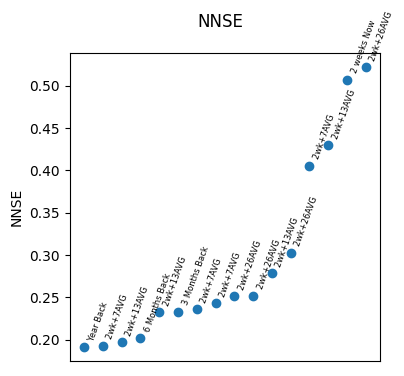

In [356]:
fig, ax = plt.subplots()
df_training['index'] = range(1, len(df_training) + 1)
ax.scatter(x=df_training['index'], y=df_training['NNSE'])
fig.set_size_inches(4,4)
fig.suptitle('NNSE')
# plt.xlabel('index')
plt.ylabel('NNSE')
# generated_df.plot(x='i', y='MSE Full', kind='scatter', figsize=(4,4), title=mse)
for idx, row in df_training.iterrows():
    ax.annotate('   ' + row['2weekIntervals'], (row['index'], row['NNSE']), rotation=70, fontsize=6)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
plt.show()

<Figure size 640x480 with 0 Axes>

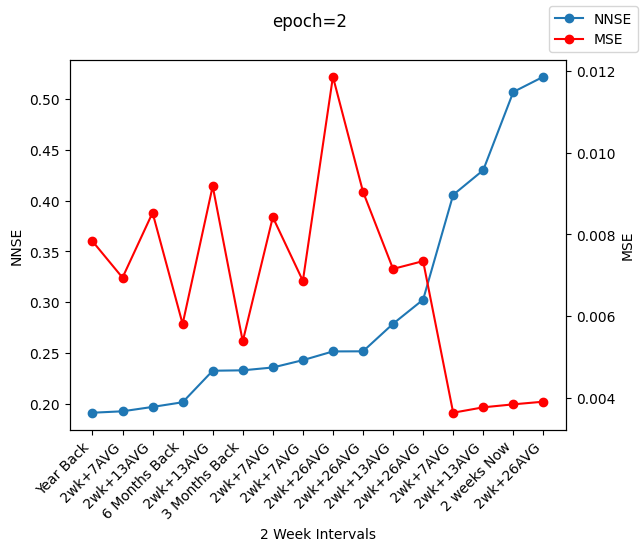

In [357]:
plt.clf()

df_training['MSE'] = df_training['MSE'].astype(float)

# this just creates a new index column
df_training['index'] = range(0, len(df_training))

# fig1, ax = plt.subplots()
# fig1.set_size_inches(20,20)
ax = df_training.plot(x='2weekIntervals', y='NNSE', marker="o", legend=False)
# ax.scatter(x=df_training['2weekIntervals'], y=df_training['NNSE'])
ax1 = ax.twinx()
df_training.plot(x='2weekIntervals', y='MSE', ax=ax1, color='r', marker="o", legend=False)
# ax1.scatter(x=df_training['2weekIntervals'], y=df_training['MSE'], color='r')
# df_training.plot(x="MSE_F", y='index', legend=False, color="r")
# plt.xticks(range(len(df_training['2weekIntervals'])), df_training['2weekIntervals'])
ax.figure.legend()
plt.suptitle('epoch=2')
plt.xticks(df_training['index'], df_training['2weekIntervals'])
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("2 Week Intervals")
ax.set_ylabel("NNSE")
ax1.set_ylabel("MSE")

plt.show()
# df_training['sortedNNSE'] = df_training.groupby('NNSEdecimal', sort=True)['2weekIntervals'].rank(ascending=False)
# df_training.sort_values(['sortedNNSE', '2weekIntervals'])
# # df_training.sort_values(['2weekIntervals', 'NNSEdecimal'], ascending=[False, False], inplace=True)
# plt.plot(df_training['NNSEdecimal'])
# plt.xticks(range(len(df_training['2weekIntervals'])), df_training['2weekIntervals'])
# plt.show()

In [358]:
result_training = df_training.copy()
result_validation = df_validation.copy()

In [359]:
result_training = result_training[['NNSE', '2weekIntervals']]
result_training.sort_values('NNSE', inplace=True)
result_training.rename(columns={'2weekIntervals': '2 Week Intervals'}, inplace=True)
display(result_training)

result_validation = result_validation[['NNSE', '2weekIntervals']]
result_validation.sort_values('NNSE', inplace=True)
result_validation.rename(columns={'2weekIntervals': '2 Week Intervals'}, inplace=True)
display(result_validation)

,NNSE,2 Week Intervals
3,0.1913,Year Back
6,0.1927,2wk+7AVG
10,0.1970,2wk+13AVG
2,0.2016,6 Months Back
11,0.2326,2wk+13AVG
1,0.2330,3 Months Back
7,0.2358,2wk+7AVG
5,0.2430,2wk+7AVG
15,0.2516,2wk+26AVG
14,0.2517,2wk+26AVG


,NNSE,2 Week Intervals
6,0.1952,2wk+7AVG
2,0.2010,6 Months Back
10,0.2016,2wk+13AVG
3,0.2045,Year Back
1,0.2197,3 Months Back
5,0.2289,2wk+7AVG
11,0.2382,2wk+13AVG
7,0.2495,2wk+7AVG
14,0.2644,2wk+26AVG
9,0.2662,2wk+13AVG


In [360]:
content = result_training[['NNSE', '2 Week Intervals']].style.hide(axis="index").to_latex().splitlines()
content.insert(2, '\\hline')
content.insert(-1, '\\hline')
table_file = Shell.map_filename('../../report/tables/abc.tex').path
# content = content.replace("\\begin{tabular}{lrl}", "\\begin{tabular}{lrl}\n\hline")
# content = content.replace('\\\\', '\\\\\\hline', 1)
writefile(table_file, '\n'.join(content))

In [361]:
content = result_validation[['NNSE', '2 Week Intervals']].style.hide(axis="index").to_latex().splitlines()
content.insert(2, '\\hline')
content.insert(-1, '\\hline')
table_file = Shell.map_filename('../../report/tables/def.tex').path
# content = content.replace("\\begin{tabular}{lrl}", "\\begin{tabular}{lrl}\n\hline")
# content = content.replace('\\\\', '\\\\\\hline', 1)
writefile(table_file, '\n'.join(content))

## MSE Analysis

In [362]:
mynotebook = readfile(notebook)
list_of_mllogs = []

count_lines = 0
for line in mynotebook.splitlines():
    #line.replace('\\', '')
    if 'MSE Full' in line and 'MSE Start' in line:
        list_of_mllogs.append(line)
        count_lines += 1
        if verbose:
            print(line)

if verbose:
    print(count_lines)

In [363]:
fixed_dicts = []
list_of_dicts_of_values = []
for mllog in list_of_mllogs:
    working_line = mllog.strip()
    # print(type(working_line))
    # print(working_line)
    working_line = working_line.replace(':::MLLOG ', '')
    # print('a', working_line)
    working_line = working_line[:-3]
    # print('b', working_line)
    working_line = working_line.replace('\\', '')
    # print('c', working_line)
    working_line = working_line.split(', "metadata":', 1)[0]
    working_line += '}'
    working_line = eval(working_line)
    working_line['value'] = eval(working_line['value'])
    list_of_dicts_of_values.append(working_line['value'])


In [364]:
df_mse = pd.DataFrame(list_of_dicts_of_values)

In [365]:
display(df_mse)

,result,RunTFTCustomVersion MSE,MSE_event_num,i,name,IndE^2/IndObs^2,IndE/IndObs,summedErr/SummedObs,line,MSE Full,MSE Start,MSE End,MSE Total
0,True,0,0,0,Next Magnitude 2 weeks Now,87.88,122.78,49.22,AVG MSE All Time Full 0.003902 Start Full 0....,0.003839,0.003048,0.004780,47.01%
1,True,1,1,1,Next Mag 3 Months Back,64.55,71.19,22.67,AVG MSE All Time Full 0.005393 Start Full 0....,0.005381,0.005797,0.004886,21.97%
2,True,2,2,2,Next Mag 6 Months Back,58.29,61.35,19.95,AVG MSE All Time Full 0.00584 Start Full 0.0...,0.005805,0.006474,0.005009,20.1%
3,True,3,3,3,Next Mag Year Back,58.17,62.45,19.33,AVG MSE All Time Full 0.007932 Start Full 0....,0.007831,0.008627,0.006883,20.45%
4,True,4,4,4,Magnitude 2 weeks Now 2wk+2,85.84,112.55,45.42,AVG MSE All Time Full 0.003725 Start Full 0....,0.003669,0.002936,0.004543,43.23%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,True,99,99,99,Mag Year Back 2wk+25,70.96,79.86,25.21,AVG MSE All Time Full 0.011817 Start Full 0....,0.011721,0.012587,0.010657,26.63%
100,True,100,100,100,Magnitude 2 weeks Now 2wk+26,88.41,109.58,51.20,AVG MSE All Time Full 0.003968 Start Full 0....,0.003904,0.003166,0.004811,50.23%
101,True,101,101,101,Mag 3 Months Back 2wk+26,75.29,82.31,30.00,AVG MSE All Time Full 0.007335 Start Full 0....,0.007344,0.007491,0.007164,29.58%
102,True,102,102,102,Mag 6 Months Back 2wk+26,72.63,81.70,25.31,AVG MSE All Time Full 0.009062 Start Full 0....,0.009043,0.009572,0.008392,26.44%


0        Text(0, 0.003839, 'Next Magnitude 2 weeks Now')
1            Text(1, 0.005381, 'Next Mag 3 Months Back')
2            Text(2, 0.005805, 'Next Mag 6 Months Back')
3                Text(3, 0.007831, 'Next Mag Year Back')
4       Text(4, 0.003669, 'Magnitude 2 weeks Now 2wk+2')
                             ...                        
99            Text(99, 0.011721, 'Mag Year Back 2wk+25')
100    Text(100, 0.003904, 'Magnitude 2 weeks Now 2wk...
101      Text(101, 0.007344, 'Mag 3 Months Back 2wk+26')
102      Text(102, 0.009043, 'Mag 6 Months Back 2wk+26')
103          Text(103, 0.011856, 'Mag Year Back 2wk+26')
Length: 104, dtype: object

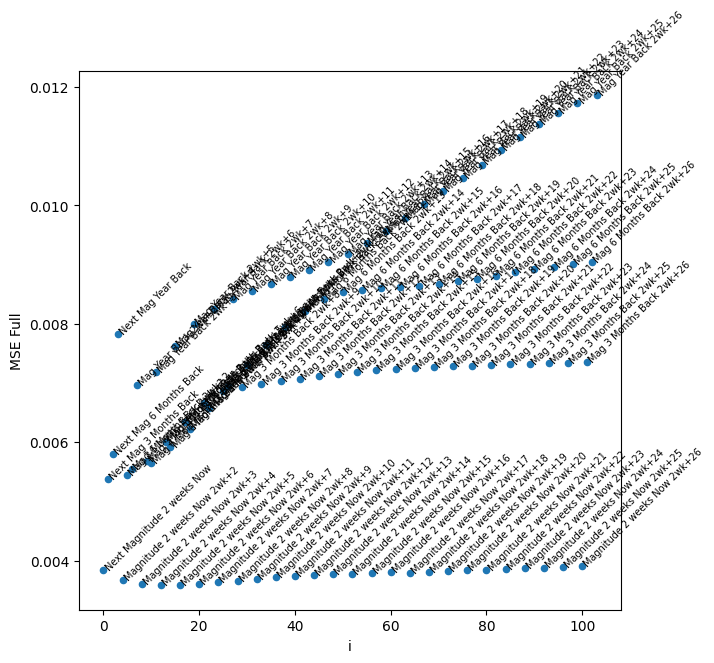

In [366]:
ax = df_mse.plot(x='i', y='MSE Full', kind='scatter', figsize=(7,7))
df_mse[['i', 'MSE Full', 'name']].apply(lambda x: ax.text(*x, rotation=45, fontsize=7),axis=1)

C:\Users\stapm\AppData\Local\Temp\ipykernel_33708\2990677531.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df['index'] = range(1, len(generated_df) + 1)
C:\Users\stapm\AppData\Local\Temp\ipykernel_33708\2990677531.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df.loc[index, '2weekIntervals'] = generated_df.loc[index, 'name'].split()[-1]


,result,RunTFTCustomVersion MSE,MSE_event_num,i,name,IndE^2/IndObs^2,IndE/IndObs,summedErr/SummedObs,line,MSE Full,MSE Start,MSE End,MSE Total,index,2weekIntervals
0,True,0,0,0,Next Magnitude 2 weeks Now,87.88,122.78,49.22,AVG MSE All Time Full 0.003902 Start Full 0....,0.003839,0.003048,0.004780,47.01%,1,Now
4,True,4,4,4,Magnitude 2 weeks Now 2wk+2,85.84,112.55,45.42,AVG MSE All Time Full 0.003725 Start Full 0....,0.003669,0.002936,0.004543,43.23%,2,2wk+2
8,True,8,8,8,Magnitude 2 weeks Now 2wk+3,85.06,108.80,43.05,AVG MSE All Time Full 0.003659 Start Full 0....,0.003607,0.002905,0.004445,40.87%,3,2wk+3
12,True,12,12,12,Magnitude 2 weeks Now 2wk+4,84.74,107.90,40.95,AVG MSE All Time Full 0.003633 Start Full 0....,0.003583,0.002901,0.004398,39.05%,4,2wk+4
16,True,16,16,16,Magnitude 2 weeks Now 2wk+5,84.74,107.92,39.72,AVG MSE All Time Full 0.003635 Start Full 0....,0.003586,0.002914,0.004390,38.13%,5,2wk+5
20,True,20,20,20,Magnitude 2 weeks Now 2wk+6,84.96,108.55,39.51,AVG MSE All Time Full 0.003655 Start Full 0....,0.003606,0.002942,0.004402,38.01%,6,2wk+6
24,True,24,24,24,Magnitude 2 weeks Now 2wk+7,85.28,110.06,39.25,AVG MSE All Time Full 0.003684 Start Full 0....,0.003634,0.002973,0.004427,37.97%,7,2wk+7
28,True,28,28,28,Magnitude 2 weeks Now 2wk+8,85.58,111.22,39.28,AVG MSE All Time Full 0.003712 Start Full 0....,0.003661,0.002999,0.004457,38.19%,8,2wk+8
32,True,32,32,32,Magnitude 2 weeks Now 2wk+9,85.87,111.96,39.76,AVG MSE All Time Full 0.003739 Start Full 0....,0.003688,0.003024,0.004487,38.75%,9,2wk+9
36,True,36,36,36,Magnitude 2 weeks Now 2wk+10,86.21,113.07,40.67,AVG MSE All Time Full 0.00377 Start Full 0.0...,0.003718,0.003051,0.004520,39.67%,10,2wk+10


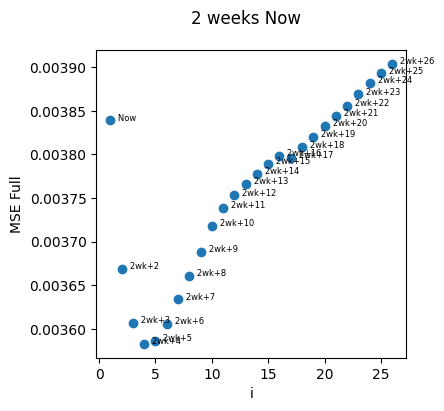

C:\Users\stapm\AppData\Local\Temp\ipykernel_33708\2990677531.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df['index'] = range(1, len(generated_df) + 1)
C:\Users\stapm\AppData\Local\Temp\ipykernel_33708\2990677531.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df.loc[index, '2weekIntervals'] = generated_df.loc[index, 'name'].split()[-1]


,result,RunTFTCustomVersion MSE,MSE_event_num,i,name,IndE^2/IndObs^2,IndE/IndObs,summedErr/SummedObs,line,MSE Full,MSE Start,MSE End,MSE Total,index,2weekIntervals
1,True,1,1,1,Next Mag 3 Months Back,64.55,71.19,22.67,AVG MSE All Time Full 0.005393 Start Full 0....,0.005381,0.005797,0.004886,21.97%,1,Back
5,True,5,5,5,Mag 3 Months Back 2wk+2,64.91,69.76,22.38,AVG MSE All Time Full 0.005456 Start Full 0....,0.005444,0.005837,0.004976,21.7%,2,2wk+2
9,True,9,9,9,Mag 3 Months Back 2wk+3,66.30,70.62,22.53,AVG MSE All Time Full 0.005693 Start Full 0....,0.005683,0.006045,0.005250,21.81%,3,2wk+3
13,True,13,13,13,Mag 3 Months Back 2wk+4,68.14,73.02,22.50,AVG MSE All Time Full 0.006015 Start Full 0....,0.006008,0.006348,0.005601,21.85%,4,2wk+4
17,True,17,17,17,Mag 3 Months Back 2wk+5,69.98,75.67,22.50,AVG MSE All Time Full 0.006346 Start Full 0....,0.006343,0.006669,0.005952,21.93%,5,2wk+5
21,True,21,21,21,Mag 3 Months Back 2wk+6,71.70,78.19,22.87,AVG MSE All Time Full 0.006664 Start Full 0....,0.006664,0.006988,0.006277,22.21%,6,2wk+6
25,True,25,25,25,Mag 3 Months Back 2wk+7,72.73,79.52,23.73,AVG MSE All Time Full 0.006858 Start Full 0....,0.006861,0.007180,0.006479,22.89%,7,2wk+7
29,True,29,29,29,Mag 3 Months Back 2wk+8,73.04,79.60,24.63,AVG MSE All Time Full 0.006919 Start Full 0....,0.006923,0.007233,0.006550,23.71%,8,2wk+8
33,True,33,33,33,Mag 3 Months Back 2wk+9,73.30,79.61,25.35,AVG MSE All Time Full 0.00697 Start Full 0.0...,0.006975,0.007281,0.006606,24.4%,9,2wk+9
37,True,37,37,37,Mag 3 Months Back 2wk+10,73.53,79.64,25.90,AVG MSE All Time Full 0.007018 Start Full 0....,0.007023,0.007328,0.006655,24.98%,10,2wk+10


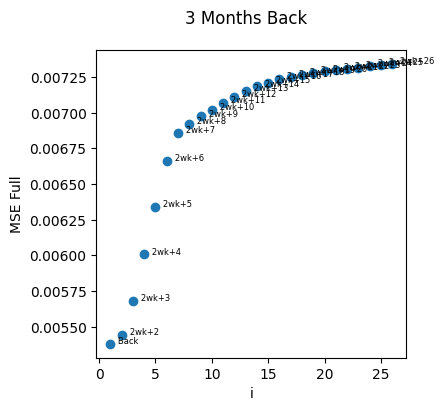

C:\Users\stapm\AppData\Local\Temp\ipykernel_33708\2990677531.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df['index'] = range(1, len(generated_df) + 1)
C:\Users\stapm\AppData\Local\Temp\ipykernel_33708\2990677531.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df.loc[index, '2weekIntervals'] = generated_df.loc[index, 'name'].split()[-1]


,result,RunTFTCustomVersion MSE,MSE_event_num,i,name,IndE^2/IndObs^2,IndE/IndObs,summedErr/SummedObs,line,MSE Full,MSE Start,MSE End,MSE Total,index,2weekIntervals
2,True,2,2,2,Next Mag 6 Months Back,58.29,61.35,19.95,AVG MSE All Time Full 0.00584 Start Full 0.0...,0.005805,0.006474,0.005009,20.1%,1,Back
6,True,6,6,6,Mag 6 Months Back 2wk+2,56.96,59.24,18.12,AVG MSE All Time Full 0.005577 Start Full 0....,0.005538,0.006189,0.004762,18.69%,2,2wk+2
10,True,10,10,10,Mag 6 Months Back 2wk+3,57.55,59.23,18.09,AVG MSE All Time Full 0.005696 Start Full 0....,0.005653,0.006297,0.004884,18.83%,3,2wk+3
14,True,14,14,14,Mag 6 Months Back 2wk+4,58.83,60.30,18.41,AVG MSE All Time Full 0.005953 Start Full 0....,0.005910,0.006552,0.005142,19.16%,4,2wk+4
18,True,18,18,18,Mag 6 Months Back 2wk+5,60.36,61.89,18.74,AVG MSE All Time Full 0.006268 Start Full 0....,0.006228,0.006872,0.005458,19.39%,5,2wk+5
22,True,22,22,22,Mag 6 Months Back 2wk+6,61.98,63.88,18.97,AVG MSE All Time Full 0.00661 Start Full 0.0...,0.006576,0.007231,0.005791,19.51%,6,2wk+6
26,True,26,26,26,Mag 6 Months Back 2wk+7,63.62,66.18,19.06,AVG MSE All Time Full 0.006968 Start Full 0....,0.006939,0.007617,0.006126,19.52%,7,2wk+7
30,True,30,30,30,Mag 6 Months Back 2wk+8,65.21,68.56,19.02,AVG MSE All Time Full 0.007322 Start Full 0....,0.007299,0.008000,0.006457,19.51%,8,2wk+8
34,True,34,34,34,Mag 6 Months Back 2wk+9,66.68,70.80,19.01,AVG MSE All Time Full 0.007657 Start Full 0....,0.007641,0.008362,0.006772,19.55%,9,2wk+9
38,True,38,38,38,Mag 6 Months Back 2wk+10,67.97,72.72,19.13,AVG MSE All Time Full 0.007958 Start Full 0....,0.007948,0.008686,0.007058,19.7%,10,2wk+10


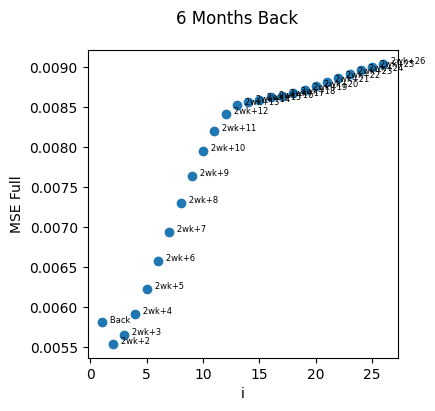

C:\Users\stapm\AppData\Local\Temp\ipykernel_33708\2990677531.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df['index'] = range(1, len(generated_df) + 1)
C:\Users\stapm\AppData\Local\Temp\ipykernel_33708\2990677531.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df.loc[index, '2weekIntervals'] = generated_df.loc[index, 'name'].split()[-1]


,result,RunTFTCustomVersion MSE,MSE_event_num,i,name,IndE^2/IndObs^2,IndE/IndObs,summedErr/SummedObs,line,MSE Full,MSE Start,MSE End,MSE Total,index,2weekIntervals
3,True,3,3,3,Next Mag Year Back,58.17,62.45,19.33,AVG MSE All Time Full 0.007932 Start Full 0....,0.007831,0.008627,0.006883,20.45%,1,Back
7,True,7,7,7,Mag Year Back 2wk+2,54.91,55.80,20.01,AVG MSE All Time Full 0.00707 Start Full 0.0...,0.006966,0.007654,0.006146,20.66%,2,2wk+2
11,True,11,11,11,Mag Year Back 2wk+3,55.86,54.03,21.55,AVG MSE All Time Full 0.007318 Start Full 0....,0.007178,0.007610,0.006662,22.16%,3,2wk+3
15,True,15,15,15,Mag Year Back 2wk+4,57.64,54.07,22.67,AVG MSE All Time Full 0.007796 Start Full 0....,0.007620,0.007820,0.007381,23.56%,4,2wk+4
19,True,19,19,19,Mag Year Back 2wk+5,59.08,54.80,23.25,AVG MSE All Time Full 0.008191 Start Full 0....,0.007992,0.008086,0.007880,24.43%,5,2wk+5
23,True,23,23,23,Mag Year Back 2wk+6,59.98,55.75,23.54,AVG MSE All Time Full 0.008446 Start Full 0....,0.008240,0.008358,0.008099,24.84%,6,2wk+6
27,True,27,27,27,Mag Year Back 2wk+7,60.60,56.72,23.64,AVG MSE All Time Full 0.008621 Start Full 0....,0.008419,0.008635,0.008160,24.95%,7,2wk+7
31,True,31,31,31,Mag Year Back 2wk+8,61.01,57.65,23.60,AVG MSE All Time Full 0.008741 Start Full 0....,0.008549,0.008896,0.008132,24.86%,8,2wk+8
35,True,35,35,35,Mag Year Back 2wk+9,61.35,58.60,23.56,AVG MSE All Time Full 0.008843 Start Full 0....,0.008665,0.009136,0.008097,24.71%,9,2wk+9
39,True,39,39,39,Mag Year Back 2wk+10,61.71,59.48,23.51,AVG MSE All Time Full 0.008947 Start Full 0....,0.008783,0.009339,0.008112,24.51%,10,2wk+10


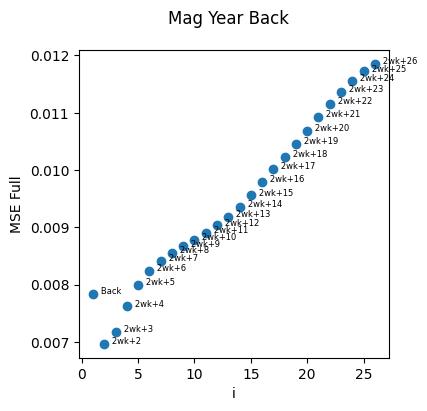

In [367]:
dataframe_dict = {}
mse_list = ['2 weeks Now', '3 Months Back', '6 Months Back', 'Mag Year Back']
for mse in mse_list:
    generated_df = df_mse[df_mse['name'].str.contains(mse)]
    generated_df['index'] = range(1, len(generated_df) + 1)
    for index, row in generated_df.iterrows():
        generated_df.loc[index, '2weekIntervals'] = generated_df.loc[index, 'name'].split()[-1]
    display(generated_df)
    dataframe_dict[mse] = generated_df
    fig, ax = plt.subplots()
    ax.scatter(x=generated_df['index'], y=generated_df['MSE Full'])
    fig.set_size_inches(4,4)
    fig.suptitle(mse)
    plt.xlabel('i')
    plt.ylabel('MSE Full')
    # generated_df.plot(x='i', y='MSE Full', kind='scatter', figsize=(4,4), title=mse)
    for idx, row in generated_df.iterrows():
        ax.annotate('   ' + row['2weekIntervals'], (row['index'], row['MSE Full']), rotation=0, fontsize=6)
    plt.show()
    # dataframe_list.append(generated_df)

2-weeks-now


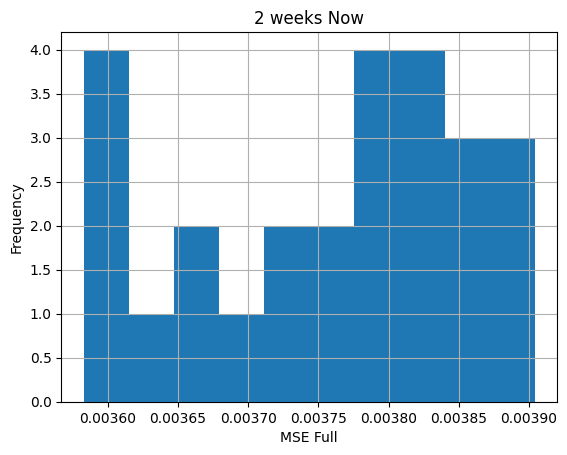

3-months-back


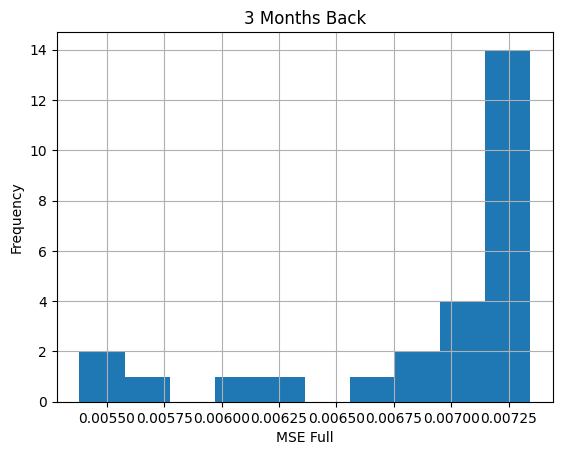

6-months-back


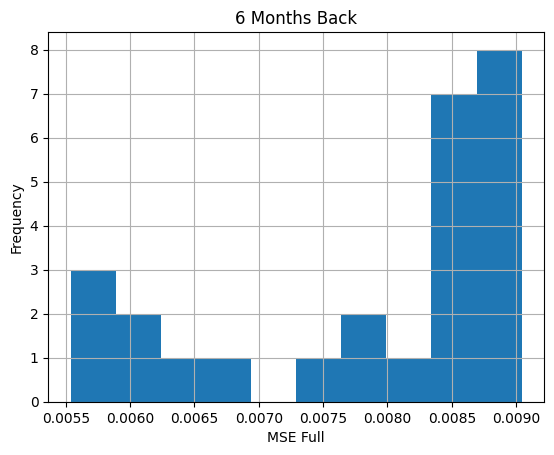

mag-year-back


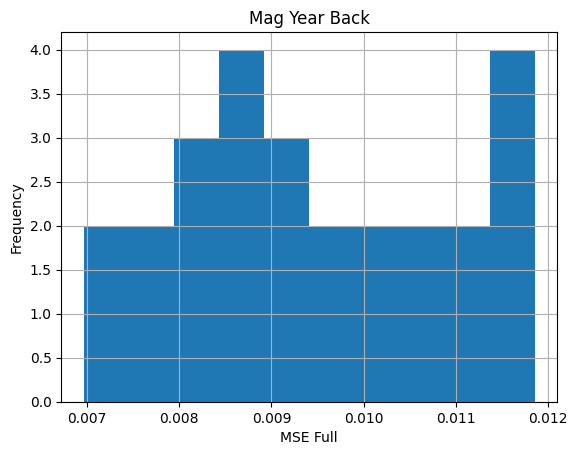

In [368]:
for key, df in dataframe_dict.items():
    df.hist(column='MSE Full')
    plt.title(key)
    plt.xlabel('MSE Full')
    plt.ylabel('Frequency')
    temp_key = key.replace(' ', '-').lower()
    print(temp_key)
    image_file = Shell.map_filename(f'../../report/images/{temp_key}.pdf').path
    plt.savefig(image_file)
    plt.show()


In [369]:
# fig, ax = plt.subplots()
# ax.scatter(x=df_mse['i'],y=df_mse['MSE Full'],c='DarkBlue')
# ax.set_xlabel('i')
# ax.set_ylabel('MSE Full')

In [370]:
# df_mse.reset_index().plot.scatter(x='index', y='MSE Full', ax=ax)

In [371]:
# for i, txt in enumerate(df_mse.result):
#     ax.annotate(txt, (df_mse['i'].iat[i], df_mse['MSE Full'].iat[i]))

In [372]:
# plt.show()

In [373]:
# import glob
# import os
# location = '/home/dje5dj/mlcommons/benchmarks/earthquake/latest/experiments/rivanna/localscratch/'
# os.system('mkdir rivanna/localscratch')
# os.system(f'rsync rivanna:{location} rivanna/localscratch')
# dirs = glob.glob(location)
# print(dirs)
# for dir in dirs:
#     pass
#     #  create image for that dir

# we assume you have an alias for rivanna in your ssh config
# we also assume that you use cms set username=XXXXXX
# where the X's are your computing id for UVA

from paramiko import SSHClient, SSHConfig, RSAKey
from scp import SCPClient

variables = Variables()

username = variables["username"]

if username is None:
    print("No username provided. Use cms set username=ComputingID")
    quit()

existing = True
localscratch = f'/home/{username}/mlcommons/benchmarks/earthquake/latest/experiments/rivanna/localscratch'
print(localscratch)

logdir = Shell.map_filename('./logs').path
epochs = ['2', '30', '70']
if not os.path.isdir(logdir):
    existing = False
    print('logs dont exist')

elif len([name for name in os.listdir(logdir) if os.path.isfile(os.path.join(logdir, name))]) != len(epochs):
    existing = False

if not existing:

    ssh = SSHClient()
    my_config = SSHConfig()

    config_path = Shell.map_filename('~/.ssh/config').path
    key_path = Shell.map_filename('~/.ssh/id_rsa').path

    import getpass
    password = getpass.getpass('Please input ssh key password. It will not be stored in the notebook.')

    mykey = RSAKey.from_private_key_file(key_path, password)

    my_config.parse(open(config_path))
    conf = my_config.lookup('rivanna')
    hostname = conf['hostname']
    ssh.load_system_host_keys()
    ssh.connect(hostname, username=username, pkey=mykey)
    Shell.mkdir(logdir)
    for epoch in epochs:
        path = f'{localscratch}/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB' \
               f'_repeat_1_TFTTransformerepochs_{epoch}/cloudmesh_mllog.log'
        with SCPClient(ssh.get_transport()) as scp:
            scp.get(path, f'./logs/cloudmesh_mllog_{epoch}.log')

/home/dje5dj/mlcommons/benchmarks/earthquake/latest/experiments/rivanna/localscratch


In [374]:
from pprint import pprint
verbose = False

dict_of_log = {}

for epoch in epochs:
    dict_of_log[epoch] = Shell.map_filename(f'./logs/cloudmesh_mllog_{epoch}.log').path

mynotebooks = {}

for key, value in dict_of_log.items():
    temp_readfile = readfile(value)
    if verbose:
        print(temp_readfile[:300])
    mynotebooks[key] = temp_readfile

count_lines = 0
dict_of_lines = {}
for epoch in epochs:
    dict_of_lines[epoch] = []

for key, value in list(mynotebooks.items()):
    for line in value.splitlines():
        #line.replace('\\', '')
        if 'F=' in line and 'S=' in line and 'E=' in line and 'NNSE' in line:
            dict_of_lines[key].append(line)

            count_lines += 1
            if verbose:
                print(line)

if verbose:
    print(count_lines)

In [375]:
print(len(dict_of_lines['2']))
print(len(dict_of_lines['30']))
print(len(dict_of_lines['70']))
# print(dict_of_lines['2'])


32
32
32


In [376]:

# pprint(fixed_dicts)
# print(len(dict_of_lines.values()))
dict_of_epochs = {}
for key, value in dict_of_lines.items():
    # print(len(value))
    # print(key)
    for iterated_line in value:
        # print(iterated_line)
        working_line = iterated_line.strip()
        # print(type(working_line))
        # print(working_line)
        working_line = working_line.replace(':::MLLOG ', '')
        # print('a', working_line)
        working_line = working_line[:-3]
        # print('b', working_line)
        working_line = working_line.replace('\\', '')
        # print('c', working_line)
        working_line = working_line.split(', "metadata":', 1)[0]
        working_line += '}'
        working_line = eval(working_line)
        working_line['value'] = eval(working_line['value'])
        # print('d', working_line)
        # print(type(working_line))

        # interpreting scientific values
        parse_line = working_line['value']['extrastring']
        parse_list = parse_line.split()

        # this function returns the value after a specified word
        def looking_for(seeking_value: str):
            found_it = False
            for word in parse_list:
                if found_it:
                    return word
                if word == seeking_value:
                    found_it = True
                    continue

        validation_value = looking_for('Validation')
        if validation_value:
            working_line['value']['validation'] = validation_value
        training_value = looking_for('Training')
        if training_value:
            working_line['value']['training'] = training_value

        list_of_values = []
        working_line['value']['MSE'] = {}
        for word in parse_list:
            if '=' in word and ('F' in word or 'S' in word or 'E' in word):
                temp_word = word.split('=')
                working_line['value']['MSE'][temp_word[0]] = temp_word[1]
            elif 'A:' in word or 'AV:' in word or 'S:' in word or 'SV:' in word:
                temp_word = word.split(':')
                working_line['value'][temp_word[0]] = temp_word[1]
            elif 'A:' in word or 'AT:' in word or 'S:' in word or 'ST:' in word:
                temp_word = word.split(':')
                working_line['value'][temp_word[0]] = temp_word[1]
        working_line['value']['title'] = working_line['key']
        working_line['key'] = 'result'

        program_title = looking_for('UTC')
        working_line['value']['program'] = program_title
        nnse = looking_for('summedErr/SummedObs')
        working_line['value']['NNSE'] = nnse
        comment = looking_for('TOTAL')
        working_line['value']['comment'] = comment

        future = re.search('FUTURE (.*) MSE', working_line['value']['extrastring'])
        try:
            working_line['value']['future'] = future.group(1)
        except AttributeError:
            pass

        loc_sum = re.search('Location Summed Results (.*),', working_line['value']['extrastring'])
        working_line['value']['location_summed_results'] = loc_sum.group(1)
        del working_line['value']['extrastring']
        # pprint(working_line)

        try:
            if not dict_of_epochs[key]:
                dict_of_epochs[key] = []
        except KeyError:
            dict_of_epochs[key] = []

        dict_of_epochs[key].append(working_line)
        # fixed_dicts[key].append(working_line)


In [377]:
if verbose:

    pprint(dict_of_epochs)
        # print(working_line)
print(dict_of_epochs.keys())

print(type(dict_of_epochs['2']))
print(type(dict_of_epochs['2'][0]))
print(len(dict_of_epochs['2']))
print(len(dict_of_epochs['30']))
print(len(dict_of_epochs['70']))

dict_keys(['2', '30', '70'])
<class 'list'>
<class 'dict'>
32
32
32


In [378]:
# dict_of_dataframes = dict.fromkeys(dict_of_lines.keys(), [])
dict_of_dataframes = {}
for epoch in epochs:
    try:
        if not dict_of_dataframes[f'{epoch}_training']:
            dict_of_dataframes[f'{epoch}_training'] = None
    except KeyError:
        dict_of_dataframes[f'{epoch}_training'] = None
        # dict_of_epochs[key].append(working_line)
    try:
        if not dict_of_dataframes[f'{epoch}_validation']:
            dict_of_dataframes[f'{epoch}_validation'] = None
    except KeyError:
        dict_of_dataframes[f'{epoch}_validation'] = None
        # dict_of_epochs[key].append(working_line)

for key, value in dict_of_epochs.items():
    list_of_value_dicts_training = []
    list_of_value_dicts_validation = []
    fails = 0
    for dictionary in value:
        # try:
        #     if dictionary['value']['training']:
        #         list_of_value_dicts_training.append(dictionary['value'])
        # except KeyError:
        #     list_of_value_dicts_validation.append(dictionary['value'])
        if dictionary.get('value', None).get('training', None):
            list_of_value_dicts_training.append(dictionary['value'])
        elif dictionary.get('value', None).get('validation', None):
            list_of_value_dicts_validation.append(dictionary['value'])
        else:
            fails += 1
    print('fails:', fails)
        #list_of_value_dicts.append(dictionary['value'])

    for iterated_dictionary in list_of_value_dicts_training:
        temp_mse = iterated_dictionary['MSE']
        iterated_dictionary['MSE_F'] = temp_mse['F']
        iterated_dictionary['MSE_S'] = temp_mse['S']
        iterated_dictionary['MSE_E'] = temp_mse['E']

    for iterated_dictionary in list_of_value_dicts_validation:
        temp_mse = iterated_dictionary['MSE']
        iterated_dictionary['MSE_F'] = temp_mse['F']
        iterated_dictionary['MSE_S'] = temp_mse['S']
        iterated_dictionary['MSE_E'] = temp_mse['E']

    df_training = pd.DataFrame(list_of_value_dicts_training)
    df_validation = pd.DataFrame(list_of_value_dicts_validation)

    df_training.drop('MSE', axis=1, inplace=True)
    df_validation.drop('MSE', axis=1, inplace=True)

    df_training.rename(columns={'NNSE': 'NNSEpercent', 'MSE_F': 'MSE'}, inplace=True)
    df_validation.rename(columns={'NNSE': 'NNSEpercent', 'MSE_F': 'MSE'}, inplace=True)

    dataframes = [df_training, df_validation]

    for dataframe in dataframes:
        for index, row in dataframe.iterrows():
            dataframe.loc[index, 'NNSE'] = float(dataframe.loc[index, 'NNSEpercent'].strip('%')) / 100.0

            if dataframe.loc[index, 'future'] is np.nan:
                temp_string_list = dataframe.loc[index, 'location_summed_results'].split()
                remove_words = ['Magnitude', 'Mag']
                for word in remove_words:
                    if word in temp_string_list:
                        temp_string_list.remove(word)
                new_string = " ".join(temp_string_list)
                dataframe.loc[index, '2weekIntervals'] = new_string

            else:
                dataframe.loc[index, '2weekIntervals'] = dataframe.loc[index, 'future'].split()[-1]
        dataframe.sort_values('NNSE', inplace=True)
    display(df_training)
    dict_of_dataframes[f'{key}_training'] = df_training
    display(df_validation)
    dict_of_dataframes[f'{key}_validation'] = df_validation

fails: 0


,training,A,AT,S,ST,title,program,NNSEpercent,comment,location_summed_results,MSE,MSE_S,MSE_E,AV,SV,future,NNSE,2weekIntervals
3,0.72242,0.582,NaN,0.614,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,19.13%,summedErr/SummedObs,Mag Year Back,0.007831,0.008627,0.006883,0.587,0.636,NaN,0.1913,Year Back
6,0.72242,0.582,0.581,0.614,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,19.27%,summedErr/SummedObs,Mag 6 Months Back,0.006939,0.007617,0.006126,NaN,NaN,Mag 6 Months Back 2wk+7AVG,0.1927,2wk+7AVG
10,0.72242,0.582,0.581,0.614,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,19.7%,summedErr/SummedObs,Mag 6 Months Back,0.008528,0.009321,0.007569,NaN,NaN,Mag 6 Months Back 2wk+13AVG,0.1970,2wk+13AVG
2,0.72242,0.582,0.581,0.614,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,20.16%,summedErr/SummedObs,Mag 6 Months Back,0.005805,0.006474,0.005009,NaN,NaN,NaN,0.2016,6 Months Back
11,0.72242,0.582,NaN,0.614,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,23.26%,summedErr/SummedObs,Mag Year Back,0.009178,0.01006,0.008111,0.587,0.636,Mag Year Back 2wk+13AVG,0.2326,2wk+13AVG
1,0.72242,0.481,NaN,0.313,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,23.3%,summedErr/SummedObs,Mag 3 Months Back,0.005381,0.005797,0.004886,0.484,0.375,NaN,0.2330,3 Months Back
7,0.72242,0.582,NaN,0.614,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,23.58%,summedErr/SummedObs,Mag Year Back,0.008419,0.008635,0.00816,0.587,0.636,Mag Year Back 2wk+7AVG,0.2358,2wk+7AVG
5,0.72242,0.481,NaN,0.313,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,24.3%,summedErr/SummedObs,Mag 3 Months Back,0.006861,0.00718,0.006479,0.484,0.375,Mag 3 Months Back 2wk+7AVG,0.2430,2wk+7AVG
15,0.72242,0.582,NaN,0.614,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,25.16%,summedErr/SummedObs,Mag Year Back,0.011856,0.012663,0.010864,0.587,0.636,Mag Year Back 2wk+26AVG,0.2516,2wk+26AVG
14,0.72242,0.582,0.581,0.614,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,25.17%,summedErr/SummedObs,Mag 6 Months Back,0.009043,0.009572,0.008392,NaN,NaN,Mag 6 Months Back 2wk+26AVG,0.2517,2wk+26AVG


,validation,A,AT,S,ST,title,program,NNSEpercent,comment,location_summed_results,MSE,MSE_S,MSE_E,AV,SV,future,NNSE,2weekIntervals
6,0.74745,0.582,0.581,0.614,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,19.52%,summedErr/SummedObs,Mag 6 Months Back,0.007081,0.007894,0.006105,NaN,NaN,Mag 6 Months Back 2wk+7AVG,0.1952,2wk+7AVG
2,0.74745,0.582,0.581,0.614,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,20.1%,summedErr/SummedObs,Mag 6 Months Back,0.005979,0.006831,0.004965,NaN,NaN,NaN,0.2010,6 Months Back
10,0.74745,0.582,0.581,0.614,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,20.16%,summedErr/SummedObs,Mag 6 Months Back,0.008521,0.009567,0.007255,NaN,NaN,Mag 6 Months Back 2wk+13AVG,0.2016,2wk+13AVG
3,0.74745,0.582,NaN,0.614,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,20.45%,summedErr/SummedObs,Mag Year Back,0.008337,0.009206,0.007302,0.587,0.636,NaN,0.2045,Year Back
1,0.74745,0.481,NaN,0.313,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,21.97%,summedErr/SummedObs,Mag 3 Months Back,0.005441,0.006075,0.004686,0.484,0.375,NaN,0.2197,3 Months Back
5,0.74745,0.481,NaN,0.313,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,22.89%,summedErr/SummedObs,Mag 3 Months Back,0.006845,0.007471,0.006093,0.484,0.375,Mag 3 Months Back 2wk+7AVG,0.2289,2wk+7AVG
11,0.74745,0.582,NaN,0.614,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,23.82%,summedErr/SummedObs,Mag Year Back,0.009752,0.010536,0.008805,0.587,0.636,Mag Year Back 2wk+13AVG,0.2382,2wk+13AVG
7,0.74745,0.582,NaN,0.614,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,24.95%,summedErr/SummedObs,Mag Year Back,0.009429,0.009297,0.009587,0.587,0.636,Mag Year Back 2wk+7AVG,0.2495,2wk+7AVG
14,0.74745,0.582,0.581,0.614,0.607,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,26.44%,summedErr/SummedObs,Mag 6 Months Back,0.009138,0.0098,0.008325,NaN,NaN,Mag 6 Months Back 2wk+26AVG,0.2644,2wk+26AVG
9,0.74745,0.481,NaN,0.313,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,26.62%,summedErr/SummedObs,Mag 3 Months Back,0.007138,0.007723,0.006431,0.484,0.375,Mag 3 Months Back 2wk+13AVG,0.2662,2wk+13AVG


fails: 0


,training,A,AT,S,ST,title,program,NNSEpercent,comment,location_summed_results,MSE,MSE_S,MSE_E,AV,SV,future,NNSE,2weekIntervals
3,0.59831,0.813,NaN,0.891,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,4.76%,summedErr/SummedObs,Mag Year Back,0.001172,0.001398,0.000902,0.816,0.894,NaN,0.0476,Year Back
2,0.59831,0.813,0.812,0.891,0.887,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,6.95%,summedErr/SummedObs,Mag 6 Months Back,0.001314,0.001477,0.00112,NaN,NaN,NaN,0.0695,6 Months Back
7,0.59831,0.813,NaN,0.891,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,8.29%,summedErr/SummedObs,Mag Year Back,0.00291,0.003397,0.002325,0.816,0.894,Mag Year Back 2wk+7AVG,0.0829,2wk+7AVG
1,0.59831,0.521,NaN,0.52,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,8.97%,summedErr/SummedObs,Mag 3 Months Back,0.001696,0.001839,0.001525,0.526,0.606,NaN,0.0897,3 Months Back
11,0.59831,0.813,NaN,0.891,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,17.16%,summedErr/SummedObs,Mag Year Back,0.00539,0.006283,0.00431,0.816,0.894,Mag Year Back 2wk+13AVG,0.1716,2wk+13AVG
6,0.59831,0.813,0.812,0.891,0.887,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,20.81%,summedErr/SummedObs,Mag 6 Months Back,0.004772,0.005334,0.004099,NaN,NaN,Mag 6 Months Back 2wk+7AVG,0.2081,2wk+7AVG
15,0.59831,0.813,NaN,0.891,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,31.96%,summedErr/SummedObs,Mag Year Back,0.011329,0.01319,0.009041,0.816,0.894,Mag Year Back 2wk+26AVG,0.3196,2wk+26AVG
5,0.59831,0.521,NaN,0.52,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,33.03%,summedErr/SummedObs,Mag 3 Months Back,0.007084,0.007479,0.006608,0.526,0.606,Mag 3 Months Back 2wk+7AVG,0.3303,2wk+7AVG
10,0.59831,0.813,0.812,0.891,0.887,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,34.18%,summedErr/SummedObs,Mag 6 Months Back,0.008914,0.009951,0.00766,NaN,NaN,Mag 6 Months Back 2wk+13AVG,0.3418,2wk+13AVG
9,0.59831,0.521,NaN,0.52,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,39.46%,summedErr/SummedObs,Mag 3 Months Back,0.007394,0.007714,0.007007,0.526,0.606,Mag 3 Months Back 2wk+13AVG,0.3946,2wk+13AVG


,validation,A,AT,S,ST,title,program,NNSEpercent,comment,location_summed_results,MSE,MSE_S,MSE_E,AV,SV,future,NNSE,2weekIntervals
3,0.59355,0.813,NaN,0.891,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,5.05%,summedErr/SummedObs,Mag Year Back,0.00122,0.001439,0.000959,0.816,0.894,NaN,0.0505,Year Back
2,0.59355,0.813,0.812,0.891,0.887,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,7.03%,summedErr/SummedObs,Mag 6 Months Back,0.001328,0.001521,0.001099,NaN,NaN,NaN,0.0703,6 Months Back
7,0.59355,0.813,NaN,0.891,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,7.65%,summedErr/SummedObs,Mag Year Back,0.002899,0.003401,0.002297,0.816,0.894,Mag Year Back 2wk+7AVG,0.0765,2wk+7AVG
1,0.59355,0.521,NaN,0.52,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,9.04%,summedErr/SummedObs,Mag 3 Months Back,0.001718,0.001917,0.001481,0.526,0.606,NaN,0.0904,3 Months Back
11,0.59355,0.813,NaN,0.891,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,15.36%,summedErr/SummedObs,Mag Year Back,0.005315,0.006272,0.004159,0.816,0.894,Mag Year Back 2wk+13AVG,0.1536,2wk+13AVG
6,0.59355,0.813,0.812,0.891,0.887,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,18.62%,summedErr/SummedObs,Mag 6 Months Back,0.004699,0.005409,0.003848,NaN,NaN,Mag 6 Months Back 2wk+7AVG,0.1862,2wk+7AVG
15,0.59355,0.813,NaN,0.891,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,29.01%,summedErr/SummedObs,Mag Year Back,0.011106,0.01306,0.008703,0.816,0.894,Mag Year Back 2wk+26AVG,0.2901,2wk+26AVG
5,0.59355,0.521,NaN,0.52,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,29.19%,summedErr/SummedObs,Mag 3 Months Back,0.006948,0.007686,0.006062,0.526,0.606,Mag 3 Months Back 2wk+7AVG,0.2919,2wk+7AVG
10,0.59355,0.813,0.812,0.891,0.887,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,30.28%,summedErr/SummedObs,Mag 6 Months Back,0.008706,0.010054,0.007077,NaN,NaN,Mag 6 Months Back 2wk+13AVG,0.3028,2wk+13AVG
9,0.59355,0.521,NaN,0.52,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,34.34%,summedErr/SummedObs,Mag 3 Months Back,0.007218,0.007868,0.006432,0.526,0.606,Mag 3 Months Back 2wk+13AVG,0.3434,2wk+13AVG


fails: 0


,training,A,AT,S,ST,title,program,NNSEpercent,comment,location_summed_results,MSE,MSE_S,MSE_E,AV,SV,future,NNSE,2weekIntervals
1,0.58488,0.511,NaN,0.435,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,6.74%,summedErr/SummedObs,Mag 3 Months Back,0.001448,0.00158,0.001292,0.517,0.531,NaN,0.0674,3 Months Back
3,0.58488,0.832,NaN,0.894,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,7.35%,summedErr/SummedObs,Mag Year Back,0.000825,0.000997,0.000619,0.835,0.899,NaN,0.0735,Year Back
7,0.58488,0.832,NaN,0.894,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,8.31%,summedErr/SummedObs,Mag Year Back,0.002816,0.003281,0.002257,0.835,0.899,Mag Year Back 2wk+7AVG,0.0831,2wk+7AVG
2,0.58488,0.832,0.831,0.894,0.89,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,10.53%,summedErr/SummedObs,Mag 6 Months Back,0.001049,0.00117,0.000906,NaN,NaN,NaN,0.1053,6 Months Back
6,0.58488,0.832,0.831,0.894,0.89,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,13.84%,summedErr/SummedObs,Mag 6 Months Back,0.004433,0.004973,0.003785,NaN,NaN,Mag 6 Months Back 2wk+7AVG,0.1384,2wk+7AVG
11,0.58488,0.832,NaN,0.894,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,15.35%,summedErr/SummedObs,Mag Year Back,0.005282,0.006122,0.004267,0.835,0.899,Mag Year Back 2wk+13AVG,0.1535,2wk+13AVG
10,0.58488,0.832,0.831,0.894,0.89,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,25.21%,summedErr/SummedObs,Mag 6 Months Back,0.00841,0.009407,0.007204,NaN,NaN,Mag 6 Months Back 2wk+13AVG,0.2521,2wk+13AVG
14,0.58488,0.832,0.831,0.894,0.89,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,29.59%,summedErr/SummedObs,Mag 6 Months Back,0.008859,0.009673,0.007858,NaN,NaN,Mag 6 Months Back 2wk+26AVG,0.2959,2wk+26AVG
15,0.58488,0.832,NaN,0.894,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,31.88%,summedErr/SummedObs,Mag Year Back,0.011241,0.013133,0.008914,0.835,0.899,Mag Year Back 2wk+26AVG,0.3188,2wk+26AVG
5,0.58488,0.511,NaN,0.435,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,33.54%,summedErr/SummedObs,Mag 3 Months Back,0.007028,0.00743,0.006545,0.517,0.531,Mag 3 Months Back 2wk+7AVG,0.3354,2wk+7AVG


,validation,A,AT,S,ST,title,program,NNSEpercent,comment,location_summed_results,MSE,MSE_S,MSE_E,AV,SV,future,NNSE,2weekIntervals
1,0.58062,0.511,NaN,0.435,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,6.98%,summedErr/SummedObs,Mag 3 Months Back,0.001444,0.001635,0.001217,0.517,0.531,NaN,0.0698,3 Months Back
3,0.58062,0.832,NaN,0.894,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,7.12%,summedErr/SummedObs,Mag Year Back,0.000846,0.001022,0.000636,0.835,0.899,NaN,0.0712,Year Back
7,0.58062,0.832,NaN,0.894,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,8.43%,summedErr/SummedObs,Mag Year Back,0.002798,0.00328,0.00222,0.835,0.899,Mag Year Back 2wk+7AVG,0.0843,2wk+7AVG
2,0.58062,0.832,0.831,0.894,0.89,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,10.22%,summedErr/SummedObs,Mag 6 Months Back,0.001048,0.001192,0.000877,NaN,NaN,NaN,0.1022,6 Months Back
6,0.58062,0.832,0.831,0.894,0.89,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,13.37%,summedErr/SummedObs,Mag 6 Months Back,0.004364,0.005037,0.003555,NaN,NaN,Mag 6 Months Back 2wk+7AVG,0.1337,2wk+7AVG
11,0.58062,0.832,NaN,0.894,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,14.28%,summedErr/SummedObs,Mag Year Back,0.005206,0.006095,0.004131,0.835,0.899,Mag Year Back 2wk+13AVG,0.1428,2wk+13AVG
10,0.58062,0.832,0.831,0.894,0.89,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,23.54%,summedErr/SummedObs,Mag 6 Months Back,0.008241,0.009511,0.006706,NaN,NaN,Mag 6 Months Back 2wk+13AVG,0.2354,2wk+13AVG
14,0.58062,0.832,0.831,0.894,0.89,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,26.97%,summedErr/SummedObs,Mag 6 Months Back,0.008577,0.009593,0.007328,NaN,NaN,Mag 6 Months Back 2wk+26AVG,0.2697,2wk+26AVG
5,0.58062,0.511,NaN,0.435,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,29.11%,summedErr/SummedObs,Mag 3 Months Back,0.006901,0.00763,0.006026,0.517,0.531,Mag 3 Months Back 2wk+7AVG,0.2911,2wk+7AVG
15,0.58062,0.832,NaN,0.894,NaN,RunTFTCustomVersion DLResults Graph Title even...,EARTHQ-newTFTv29,29.35%,summedErr/SummedObs,Mag Year Back,0.011039,0.013003,0.008626,0.835,0.899,Mag Year Back 2wk+26AVG,0.2935,2wk+26AVG


In [379]:
for key, value in dict_of_dataframes.items():
    print(len(value))
    print(key)
    epoch = key.split('_')[0]
    training_or_validation = key.split('_')[1]
    value['epoch'] = epoch
    value['epoch'] = value['epoch'].astype(float)
    print('epoch:', epoch)

    value['type of run'] = training_or_validation
    print('type of run:', training_or_validation)

16
2_training
epoch: 2
type of run: training
16
2_validation
epoch: 2
type of run: validation
16
30_training
epoch: 30
type of run: training
16
30_validation
epoch: 30
type of run: validation
16
70_training
epoch: 70
type of run: training
16
70_validation
epoch: 70
type of run: validation


dict_keys(['2_training', '2_validation', '30_training', '30_validation', '70_training', '70_validation'])


<Figure size 640x480 with 0 Axes>

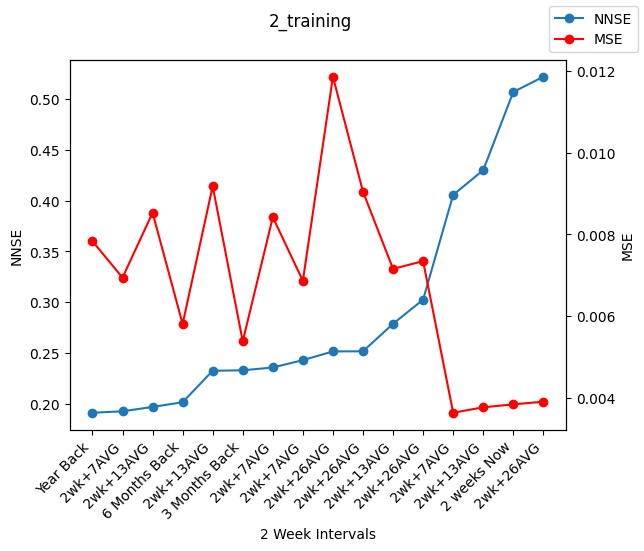

<Figure size 640x480 with 0 Axes>

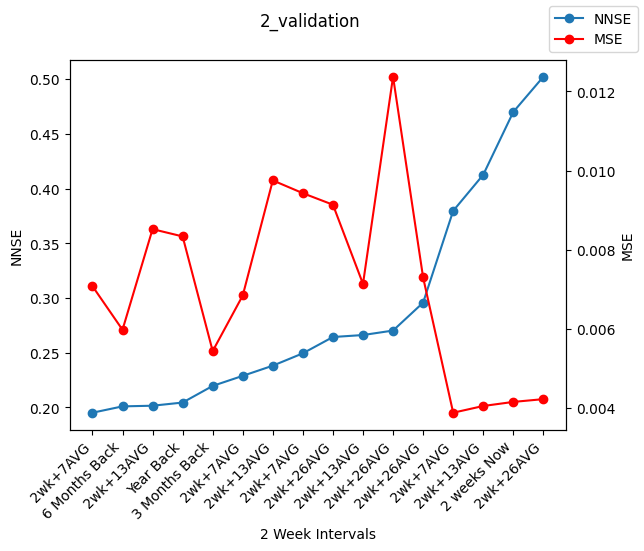

<Figure size 640x480 with 0 Axes>

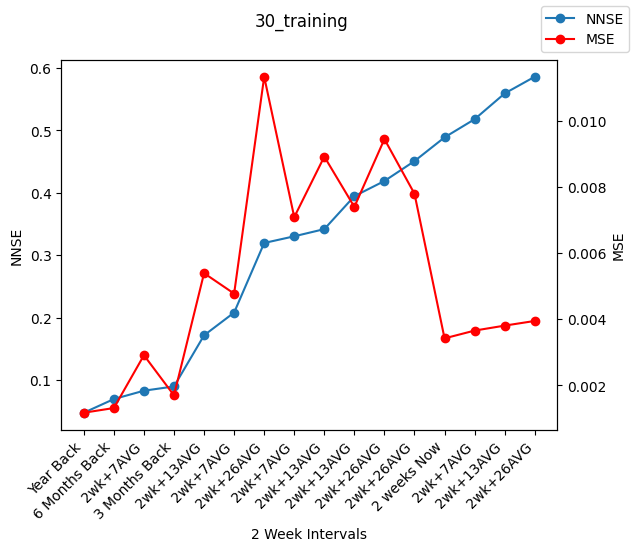

<Figure size 640x480 with 0 Axes>

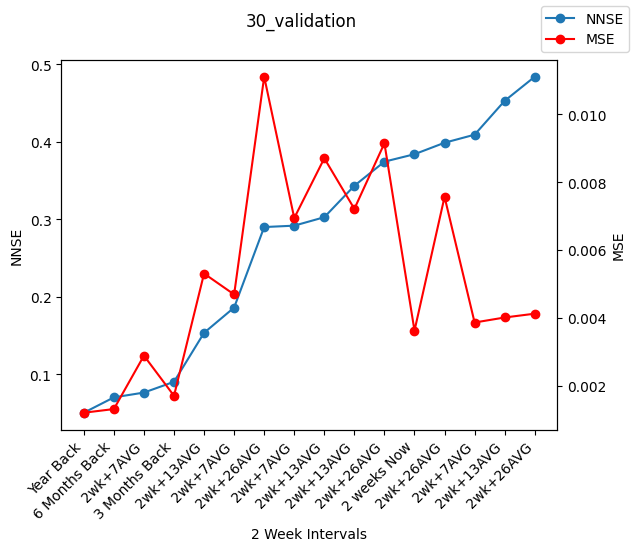

<Figure size 640x480 with 0 Axes>

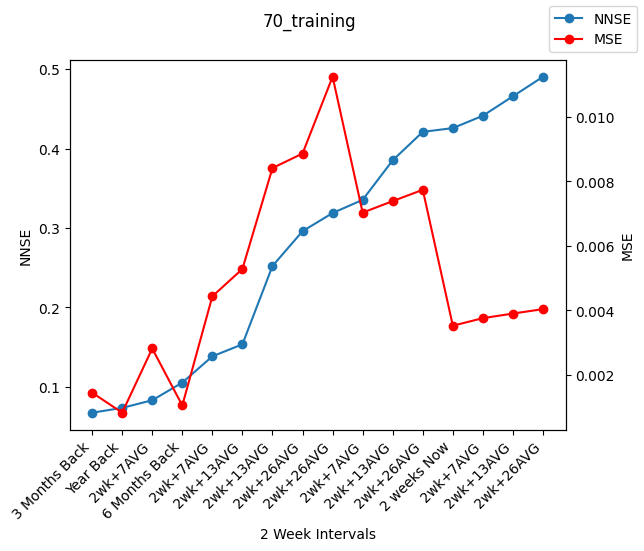

<Figure size 640x480 with 0 Axes>

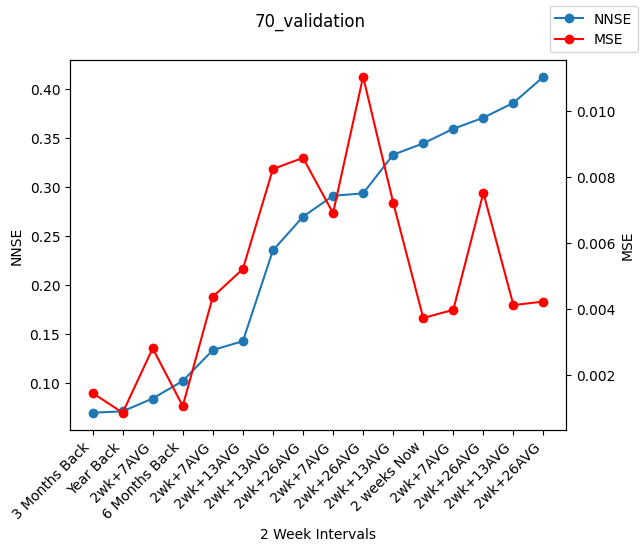

In [380]:
print(dict_of_dataframes.keys())
for key, value in dict_of_dataframes.items():
    plt.clf()
    value['MSE'] = value['MSE'].astype(float)
    value['index'] = range(0, len(value))
    ax = value.plot(x='2weekIntervals', y='NNSE', marker="o", legend=False)
    ax1 = ax.twinx()
    value.plot(x='2weekIntervals', y='MSE', ax=ax1, color='r', marker="o", legend=False)
    # value.plot(x="MSE_F", y='index', legend=False, color="r")
    # plt.xticks(range(len(value['2weekIntervals'])), value['2weekIntervals'])
    ax.figure.legend()
    plt.suptitle(key)
    plt.xticks(value['index'], value['2weekIntervals'])
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("2 Week Intervals")
    ax.set_ylabel("NNSE")
    ax1.set_ylabel("MSE")

    plt.show()
    # value['sortedNNSE'] = value.groupby('NNSEdecimal', sort=True)['2weekIntervals'].rank(ascending=False)
    # value.sort_values(['sortedNNSE', '2weekIntervals'])
    # # value.sort_values(['2weekIntervals', 'NNSEdecimal'], ascending=[False, False], inplace=True)
    # plt.plot(value['NNSEdecimal'])
    # plt.xticks(range(len(value['2weekIntervals'])), value['2weekIntervals'])
    # plt.show()

In [381]:
mega_training_dataframe = pd.DataFrame()
mega_validation_dataframe = pd.DataFrame()

training_dfs = []
validation_dfs = []
for key, value in dict_of_dataframes.items():
    if 'training' in key:
        training_dfs.append(value)
    elif 'validation' in key:
        validation_dfs.append(value)
    else:
        print('fail')

mega_training_dataframe = pd.concat(training_dfs)
mega_validation_dataframe = pd.concat(validation_dfs)

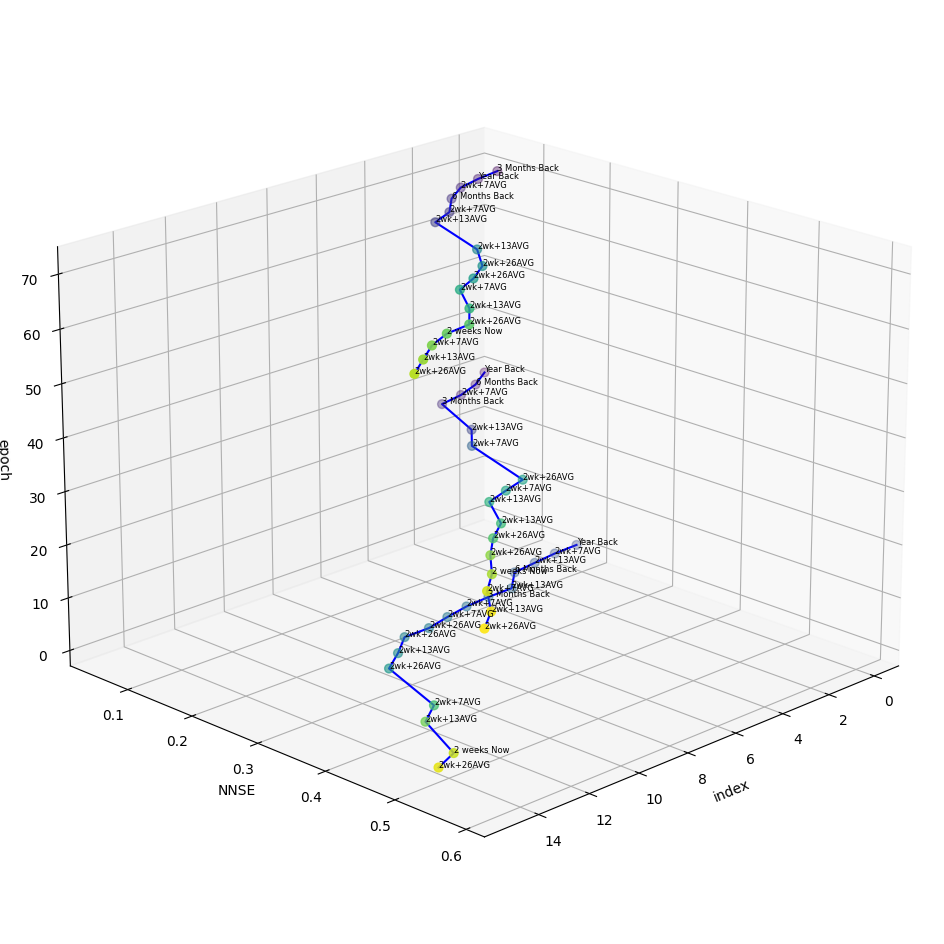

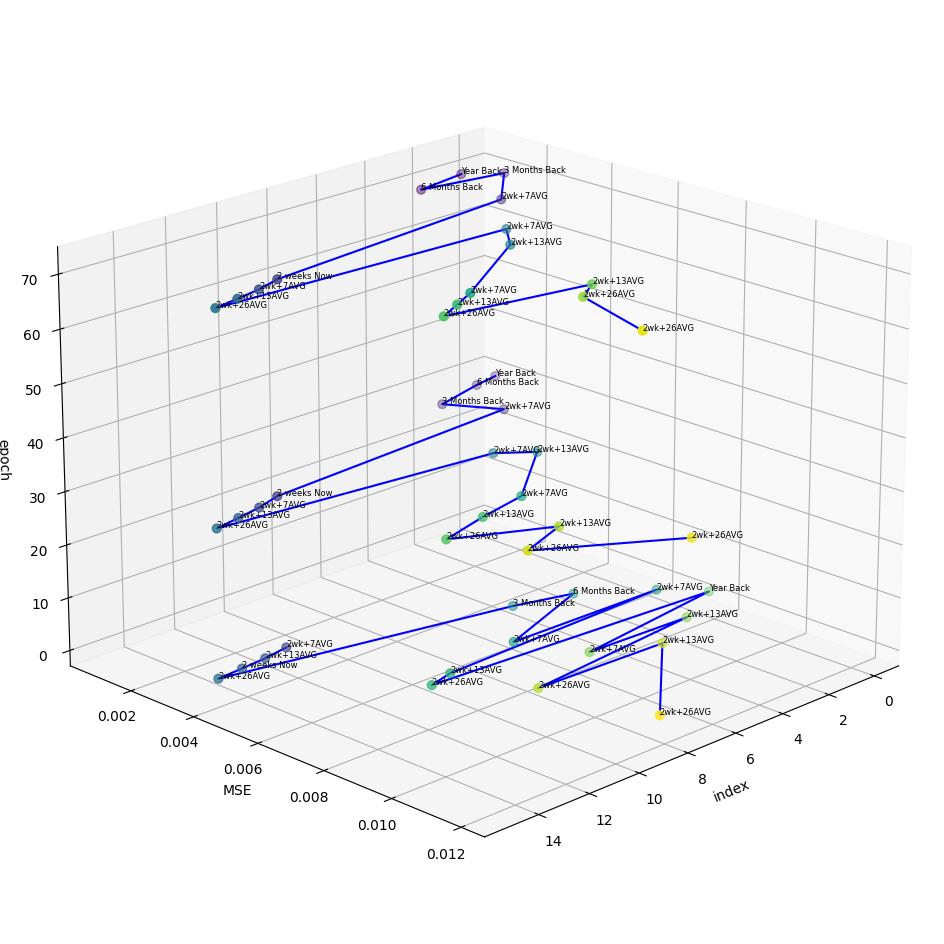

In [382]:
graphs = ['NNSE', 'MSE']
for graph_type in graphs:
    mega_training_dataframe.sort_values(graph_type, inplace=True)
    mega_validation_dataframe.sort_values(graph_type, inplace=True)

    cm = plt.get_cmap("RdYlGn")
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('index')
    ax.set_ylabel(graph_type)
    ax.set_zlabel('epoch')
    ax.scatter(mega_training_dataframe['index'],
               mega_training_dataframe[graph_type],
               mega_training_dataframe['epoch'],
               # s=range(len(mega_training_dataframe['epoch'])),
               c=range(len(mega_training_dataframe['epoch'])),
               s=40,
               marker='o')
    for i in range(len(mega_training_dataframe)):
        x, y, z = mega_training_dataframe.iloc[i]['index'], mega_training_dataframe.iloc[i][graph_type], mega_training_dataframe.iloc[i]['epoch']
        ax.text(x, y, z, '{0}'.format(mega_training_dataframe.iloc[i]['2weekIntervals']), size=6,
                rotation=80)
    for epoch in epochs:
        temp_df = mega_training_dataframe.loc[mega_training_dataframe['epoch'] == float(epoch)]
        ax.plot(
               temp_df['index'], temp_df[graph_type], temp_df['epoch'],  # data
               #color='purple',                            # marker colour
               #marker='o',                                # marker shape
               color='blue'                                       # marker size
               )
    ax.view_init(20, 45)
    plt.show()
    # for idx, row in mega_training_dataframe.iterrows():
    #     ax.annotate(row['2weekIntervals'], (row['index'], row[graph_type], row['epoch']), rotation=0, fontsize=6)


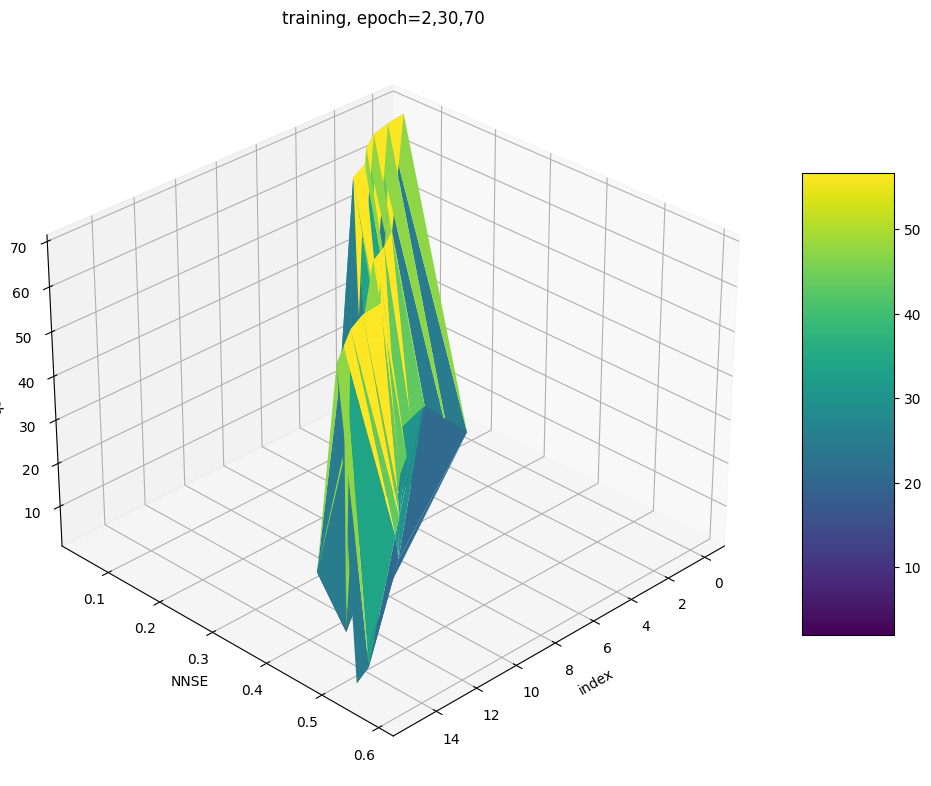

In [383]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
surf=ax.plot_trisurf(mega_training_dataframe['index'],
           mega_training_dataframe['NNSE'],
           mega_training_dataframe['epoch'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
ax.set_xlabel('index')
ax.set_ylabel('NNSE')
ax.set_zlabel('epoch')
ax.view_init(30, 45)
plt.title('training, epoch=2,30,70')
plt.show()